# Rotated MNIST

In [1]:
# Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation
import tensorflow.keras as k

from tensorflow.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

In [2]:
# Download and split mnist data
from tensorflow_core.python.framework import tensor_shape
mnist_data = tf.keras.datasets.mnist
(mnist_x_train, mnist_y_train),(mnist_x_test, mnist_y_test) = mnist_data.load_data()

# Normalize the input values to be between 0 and 1
mnist_x_train, mnist_x_test = mnist_x_train / 255.0, mnist_x_test / 255.0

* Define functions to rotate images by a multiple of 90 degrees.

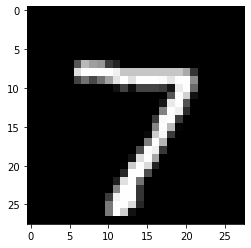

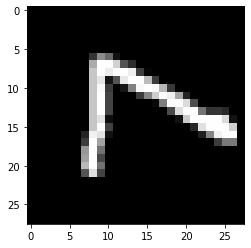

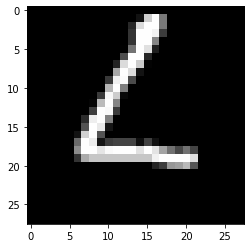

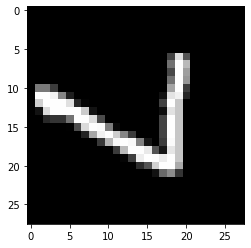

In [3]:
def rotate_matrix_counterclockwise(matrix, multiplicity):
    return matrix if multiplicity == 0 else rotate_matrix_counterclockwise(np.rot90(matrix), multiplicity -1)

# Plot rotated MNIST images

for multiplicity in range(4):
    fig = plt.figure()
    plt.imshow(rotate_matrix_counterclockwise(mnist_x_test[0],multiplicity), 'gray')

* Apply rotations on MNIST dataset

In [4]:
def generate_rotated_dataset(original_images):
    rotated_dataset = []

    for index, image in enumerate(original_images):

        # We have 4 unique rotations, so we only consider multiplicities from 0 to 3
        random_multiplicity = np.random.randint(4)

        # Aplly rotation to image
        rotated_image = rotate_matrix_counterclockwise(image, random_multiplicity)
        rotated_dataset.append(rotated_image)

    return np.array(rotated_dataset)

# Generate rotated dataset
x_train = generate_rotated_dataset(mnist_x_train)
x_test = generate_rotated_dataset(mnist_x_test)

* Generate two benchmarks with one hidden dense layer with 100 and 400 hidden units

In [8]:
# Define some training setting parameters
number_of_classes = 10
batch_size = 128
epochs = 20

# convert class vectors to binary class matrices
y_train = to_categorical(mnist_y_train, number_of_classes)
y_test = to_categorical(mnist_y_test, number_of_classes)

# Define helper function to train and evaluate the performance of the model

def train_and_evaluate_model(model, model_name):
    # Train model
    history_of_model = model.fit(x_train,y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

    # evaluate model
    score = model.evaluate(x_test, y_test, verbose=1)

    # print performance
    print('Test loss for {model_name}:'.format(model_name=model_name), score[0])
    print('Test accuracy for {model_name}:'.format(model_name=model_name), score[1])

In [9]:
# Build neural network for first benchmark
benchmark1 = Sequential()
benchmark1.add(Flatten())
benchmark1.add(Dense(100, activation='relu'))
benchmark1.add(Dense(number_of_classes, activation='softmax'))

benchmark1.compile(loss='categorical_crossentropy',
              optimizer=SGD(), metrics=['accuracy'])

# Build neural network for second benchmark
benchmark2 = Sequential()
benchmark2.add(Flatten())
benchmark2.add(Dense(400, activation='relu'))
benchmark2.add(Dense(number_of_classes, activation='softmax'))

benchmark2.compile(loss='categorical_crossentropy',
              optimizer=SGD(), metrics=['accuracy'])

train_and_evaluate_model(benchmark1, 'Benchmark 1')
train_and_evaluate_model(benchmark2, 'Benchmark 2')


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 43us/sample - loss: 1.8097 - accuracy: 0.4163 - val_loss: 1.4553 - val_accuracy: 0.5448

In [10]:
class GroupConv2D(k.layers.Layer):
    def __init__(self, input_shape):
        super(GroupConv2D, self).__init__()
        self.w = self.add_weight(shape=input_shape, initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(4,), initializer="zeros", trainable=True)

    def call(self, inputs, **kwargs):
        rotated_product = [tf.tensordot(tf.image.rot90(inputs, k=i), self.w, axes=[[1,2], [1,2]]) for i in range(4)]
        unbiased_activation = tf.stack(rotated_product, axis=2)

        return unbiased_activation + self.b

model1 = Sequential()
model1.add(GroupConv2D(input_shape=(1,28,28)))
model1.add(Activation("relu"))
model1.add(Flatten())
model1.add(Dense(number_of_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_and_evaluate_model(model1, 'test')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
  128/60000 [..............................] - ETA: 11:20

InvalidArgumentError:  Matrix size-incompatible: In[0]: [28,3584], In[1]: [784,1]
	 [[node sequential_5/group_conv2d_1/Tensordot_1/MatMul (defined at <ipython-input-10-73002eabd5ab>:8) ]] [Op:__inference_distributed_function_297911]

Function call stack:
distributed_function
